In [1]:
import warnings
import pandas as pd
import numpy as np

from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./bank-additional-full.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
data.drop('duration', axis=1, inplace=True)

In [5]:
data.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
data.skew(numeric_only=True)

age               0.784697
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64

# Підготовка й обробка даних

### Вимоги алгоритмів до обробки даних
### Очистка від викидів

In [7]:
data = data[zscore(data['campaign']).abs().lt(2)]

<Axes: >

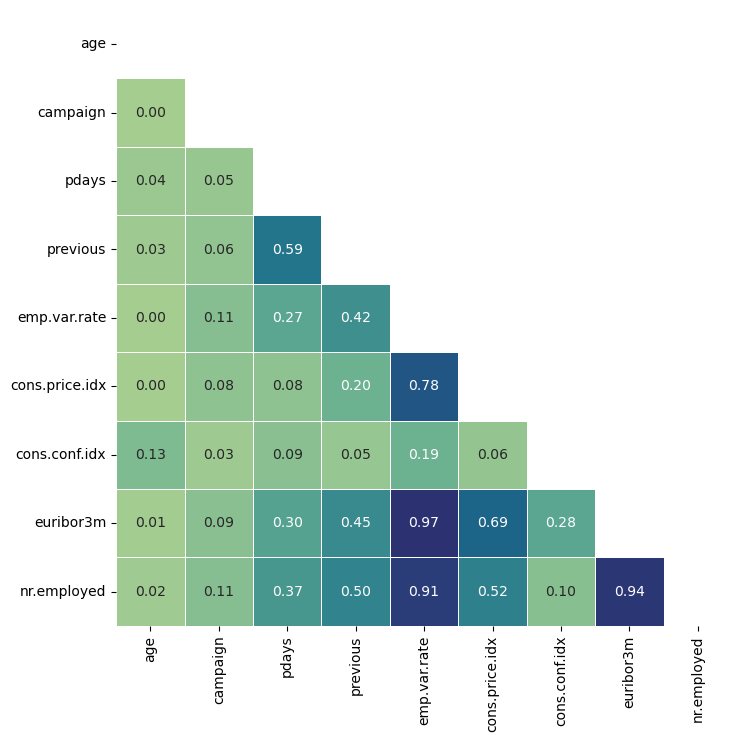

In [8]:
mtx = data.drop('y', axis=1).corr(numeric_only=True).abs()

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(mtx,
            cmap='crest',
            annot=True,
            fmt=".2f",
            linewidth=.5,
            mask=np.triu(np.ones_like(mtx, dtype=bool)),
            square=True,
            cbar=False,
            ax=ax)

In [9]:
data.drop(
    ['emp.var.rate',
     'cons.price.idx',
     'nr.employed'],
    axis=1,
    inplace=True)

In [10]:
data.select_dtypes(include='object').nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    data['y'] = data['y'].replace({'no': 0, 'yes': 1})

In [12]:
X_train, X_test, y_train, y_test = (
    train_test_split(
        data.drop('y', axis=1),
        data['y'],
        test_size=0.2,
        random_state=42))

In [13]:
cat_cols = X_train.select_dtypes(include='object').columns
cat_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [14]:
encoder = ce.WOEEncoder(cols=cat_cols)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [15]:
power_transform = PowerTransformer().set_output(transform='pandas')

X_train = power_transform.fit_transform(X_train)
X_test = power_transform.transform(X_test)

In [16]:
X_train.skew()

age              0.007984
job              0.048212
marital          0.826785
education        0.056809
default          2.514470
housing         -0.106005
loan            -1.703180
contact         -0.586952
month            0.104885
day_of_week     -0.179013
campaign         0.237176
pdays           -4.813348
previous         2.069751
poutcome         2.070238
cons.conf.idx    0.049700
euribor3m       -0.615990
dtype: float64

In [17]:
y_train.value_counts(normalize=True)

y
0    0.884514
1    0.115486
Name: proportion, dtype: float64

In [18]:
sm = SMOTE(random_state=42, k_neighbors=50)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [19]:
y_res.value_counts(normalize=True)

y
0    0.5
1    0.5
Name: proportion, dtype: float64

In [20]:
knn_mod = KNeighborsClassifier(n_neighbors=7, n_jobs=-1).fit(X_res, y_res)

knn_preds = knn_mod.predict(X_test)

knn_score = balanced_accuracy_score(y_test, knn_preds)

print(f'KNN model accuracy: {knn_score:.1%}')

KNN model accuracy: 69.8%


In [21]:
gnb_mod = GaussianNB().fit(X_res, y_res)

gnb_preds = gnb_mod.predict(X_test)

gnb_score = balanced_accuracy_score(y_test, gnb_preds)

print(f'GNB model accuracy: {gnb_score:.1%}')

GNB model accuracy: 70.9%


In [22]:
confusion_matrix(y_test, gnb_preds)

array([[5934, 1123],
       [ 384,  522]])